In [1]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras import backend as K
from tensorflow.keras import utils
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from sklearn.model_selection import KFold
from os.path import isfile
from datetime import datetime
%matplotlib inline

In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import Session

config = ConfigProto()
config.gpu_options.allow_growth = True
sess = Session(config=config)

if tf.test.gpu_device_name():
    print("GPU found")
else:
    print("No GPU found")

GPU found


## Load training and Validation arrays

In [3]:
dict_genres = {'Electronic':0, 'Experimental':1, 'Folk':2, 'Hip-Hop':3, 'Instrumental':4,'International':5, 'Pop' :6, 'Rock': 7}

reverse_map = {v: k for k, v in dict_genres.items()}
print(reverse_map)

{0: 'Electronic', 1: 'Experimental', 2: 'Folk', 3: 'Hip-Hop', 4: 'Instrumental', 5: 'International', 6: 'Pop', 7: 'Rock'}


In [4]:
npzfile = np.load('data/shuffled_train.npz')
print(npzfile.files)

X_train = npzfile['arr_0']
y_train = npzfile['arr_1']
print(X_train.shape, y_train.shape)

['arr_0', 'arr_1']
(6394, 640, 128) (6394,)


In [5]:
y_train = utils.to_categorical(y_train, num_classes=8).astype(int)
print(X_train.shape, y_train.shape)

(6394, 640, 128) (6394, 8)


In [6]:
npzfile = np.load('data/shuffled_valid.npz')
print(npzfile.files)

X_valid = npzfile['arr_0']
y_valid = npzfile['arr_1']
print(X_valid.shape, y_valid.shape)

['arr_0', 'arr_1']
(800, 640, 128) (800,)


In [7]:
y_valid = utils.to_categorical(y_valid, num_classes=8).astype(int)
print(X_valid.shape, y_valid.shape)

(800, 640, 128) (800, 8)


## Check by plotting a Spectogram

Pop


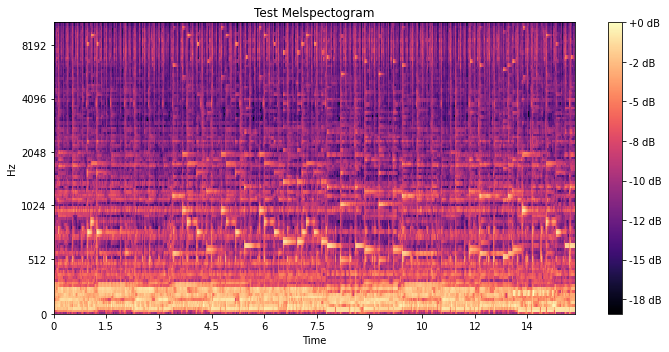

In [8]:
num = 0
spectogram = X_train[num]
genre = np.argmax(y_train[num])
print(reverse_map[genre])
plt.figure(figsize=(10, 5))
librosa.display.specshow(spectogram.T, y_axis='mel', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Test Melspectogram')
plt.tight_layout()

## Parallel CNN - RNN Model

In [9]:
batch_size = 32
num_classes = 2
n_features = X_train.shape[2]
n_time = X_train.shape[1]

In [10]:
nb_filters1=32
nb_filters2=64
nb_filters3=128
nb_filters4=512
ksize = (3,3)
pool_size_1= (2,2)

BATCH_SIZE = 64
EPOCH_COUNT = 50

def conv_recurrent_model_build(model_input):
    print('Building model...')
    layer = model_input
    
    ### Convolutional blocks
    conv_1 = Conv2D(filters = nb_filters1, kernel_size = ksize, strides=1, padding= 'valid', activation='elu', name='conv_1')(layer)
    pool_1 = MaxPooling2D(pool_size_1)(conv_1)

    conv_2 = Conv2D(filters = nb_filters2, kernel_size = ksize, strides=1, padding= 'valid', activation='elu', name='conv_2')(pool_1)
    pool_2 = MaxPooling2D(pool_size_1)(conv_2)

    conv_3 = Conv2D(filters = nb_filters3, kernel_size = ksize, strides=1, padding= 'valid', activation='elu', name='conv_3')(pool_2)
    pool_3 = MaxPooling2D(pool_size_1)(conv_3)
    
    conv_4 = Conv2D(filters = nb_filters4, kernel_size = ksize, strides=1, padding= 'valid', activation='elu', name='conv_4')(pool_3)
    pool_4 = MaxPooling2D(pool_size_1)(conv_4)
    
    flatten1 = Flatten()(pool_4)
    
    output = Dense(num_classes, activation = 'softmax', name='preds')(flatten1)
    
    model_output = output
    model = Model(model_input, model_output)
    
    opt = Adam(learning_rate=0.001)
    
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    return model

In [11]:
def train_model(x_train, y_train, x_val, y_val, info = "", genres_name = ""):
    n_frames = 640
    n_frequency = 128
    
    #reshape and expand dims for conv2d
    x_train = np.expand_dims(x_train, axis = -1)
    x_val = np.expand_dims(x_val, axis = -1)
       
    input_shape = (n_frames, n_frequency, 1)
    model_input = Input(input_shape, name='input')
    
    model = conv_recurrent_model_build(model_input)
    
    log_dir = "./logs/tree_5/model_root/"+datetime.now().strftime("%Y%m%d-%H%M%S_")+info
    tb_callback = TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=True, write_images=False, update_freq='batch', profile_batch=2, embeddings_freq=0, embeddings_metadata=None)

    model_folder = "./models/tree_5/model_root/{}".format(info)
    os.makedirs(model_folder, exist_ok=True)
    
    f = open("{}/info.txt".format(model_folder), "w")
    f.write("genre name split: {}".format(genres_name))
    checkpoint_callback = ModelCheckpoint('{}/model.h5'.format(model_folder), monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
    
    reducelr_callback = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=10, min_delta=0.01, verbose=1)
    callbacks_list = [tb_callback, checkpoint_callback, reducelr_callback]
    
    f.close()
    
    # Fit the model and get training history.
    print('Training...')
    history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCH_COUNT, validation_data=(x_val, y_val), verbose=1, callbacks=callbacks_list)
    
    return model, history

In [12]:
def chunks(lst, n):
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

In [13]:
def create_split(elem, c):
    splits = []
    for i in range(c):
        equal = False
        np.random.shuffle(elem)
        new_split = list(chunks(elem, int(len(elem)/2)))
        for split in splits:
            if set(new_split[0]) == set(split[0]) and set(new_split[0]) == set(split[1]):
                equal = True
                break
            
        if equal:
            i-=1
            continue
        
        splits.append(new_split)
        
    return splits

In [14]:
def show_summary_stats(history):
    # List all data in history
    print(history.history.keys())

    # Summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    # Summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

Folder num 1
Genre split [['International', 'Instrumental', 'Experimental', 'Hip-Hop'], ['Electronic', 'Pop', 'Folk', 'Rock']]
Building model...
Training...
Epoch 1/50
110/110 [==============================] - 32s 177ms/step - loss: 5.9753 - accuracy: 0.5386 - val_loss: 0.7505 - val_accuracy: 0.4951

Epoch 00001: val_accuracy improved from -inf to 0.49515, saving model to ./models/tree_5/model_root/folder1\model.h5
Epoch 2/50
110/110 [==============================] - 19s 169ms/step - loss: 0.6489 - accuracy: 0.6231 - val_loss: 0.5967 - val_accuracy: 0.6893

Epoch 00002: val_accuracy improved from 0.49515 to 0.68932, saving model to ./models/tree_5/model_root/folder1\model.h5
Epoch 3/50
110/110 [==============================] - 19s 169ms/step - loss: 0.6105 - accuracy: 0.6784 - val_loss: 0.6113 - val_accuracy: 0.6505

Epoch 00003: val_accuracy did not improve from 0.68932
Epoch 4/50
110/110 [==============================] - 19s 173ms/step - loss: 0.5995 - accuracy: 0.6872 - val_loss

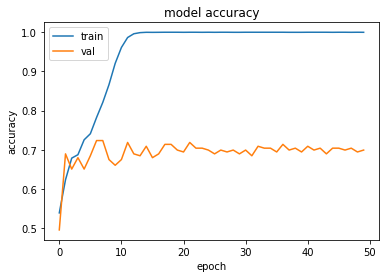

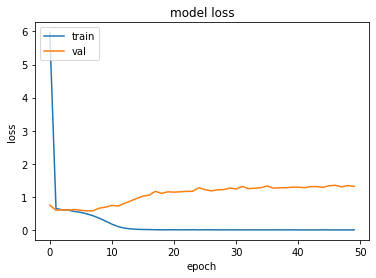

Folder num 2
Genre split [['Hip-Hop', 'Rock', 'Electronic', 'Instrumental'], ['Folk', 'International', 'Pop', 'Experimental']]
Building model...
Training...
Epoch 1/50
110/110 [==============================] - 20s 171ms/step - loss: 3.7191 - accuracy: 0.5502 - val_loss: 0.6497 - val_accuracy: 0.6699

Epoch 00001: val_accuracy improved from -inf to 0.66990, saving model to ./models/tree_5/model_root/folder2\model.h5
Epoch 2/50
110/110 [==============================] - 19s 169ms/step - loss: 0.6399 - accuracy: 0.6338 - val_loss: 0.6150 - val_accuracy: 0.6505

Epoch 00002: val_accuracy did not improve from 0.66990
Epoch 3/50
110/110 [==============================] - 20s 181ms/step - loss: 0.5873 - accuracy: 0.6820 - val_loss: 0.7072 - val_accuracy: 0.5583

Epoch 00003: val_accuracy did not improve from 0.66990
Epoch 4/50
110/110 [==============================] - 19s 171ms/step - loss: 0.5424 - accuracy: 0.7218 - val_loss: 0.6071 - val_accuracy: 0.6408

Epoch 00004: val_accuracy did no

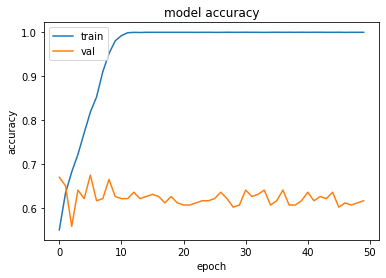

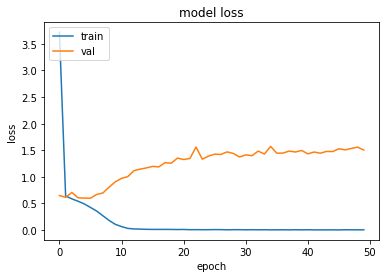

Folder num 3
Genre split [['Electronic', 'Rock', 'Experimental', 'Instrumental'], ['Pop', 'International', 'Hip-Hop', 'Folk']]
Building model...
Training...
Epoch 1/50
110/110 [==============================] - 20s 173ms/step - loss: 3.7658 - accuracy: 0.5731 - val_loss: 0.6222 - val_accuracy: 0.6796

Epoch 00001: val_accuracy improved from -inf to 0.67961, saving model to ./models/tree_5/model_root/folder3\model.h5
Epoch 2/50
110/110 [==============================] - 19s 169ms/step - loss: 0.5901 - accuracy: 0.6973 - val_loss: 0.5926 - val_accuracy: 0.7233

Epoch 00002: val_accuracy improved from 0.67961 to 0.72330, saving model to ./models/tree_5/model_root/folder3\model.h5
Epoch 3/50
110/110 [==============================] - 19s 170ms/step - loss: 0.5580 - accuracy: 0.7155 - val_loss: 0.5488 - val_accuracy: 0.7330

Epoch 00003: val_accuracy improved from 0.72330 to 0.73301, saving model to ./models/tree_5/model_root/folder3\model.h5
Epoch 4/50
110/110 [============================

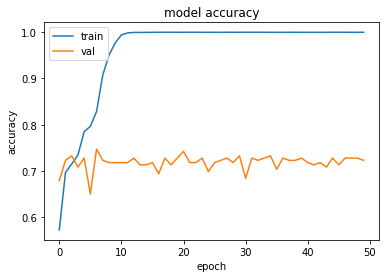

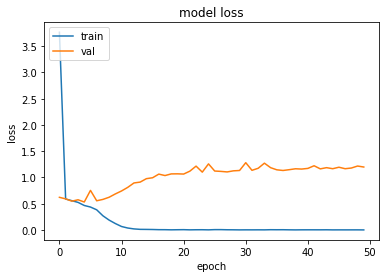

Folder num 4
Genre split [['Folk', 'International', 'Rock', 'Hip-Hop'], ['Pop', 'Experimental', 'Electronic', 'Instrumental']]
Building model...
Training...
Epoch 1/50
110/110 [==============================] - 21s 174ms/step - loss: 3.8915 - accuracy: 0.5545 - val_loss: 0.6406 - val_accuracy: 0.6311

Epoch 00001: val_accuracy improved from -inf to 0.63107, saving model to ./models/tree_5/model_root/folder4\model.h5
Epoch 2/50
110/110 [==============================] - 19s 168ms/step - loss: 0.6086 - accuracy: 0.6720 - val_loss: 0.6304 - val_accuracy: 0.6748

Epoch 00002: val_accuracy improved from 0.63107 to 0.67476, saving model to ./models/tree_5/model_root/folder4\model.h5
Epoch 3/50
110/110 [==============================] - 19s 169ms/step - loss: 0.5716 - accuracy: 0.7056 - val_loss: 0.6237 - val_accuracy: 0.6796

Epoch 00003: val_accuracy improved from 0.67476 to 0.67961, saving model to ./models/tree_5/model_root/folder4\model.h5
Epoch 4/50
110/110 [============================

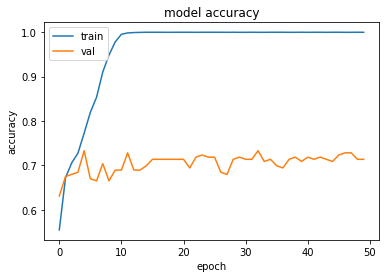

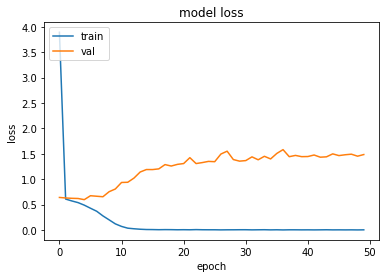

Folder num 5
Genre split [['Pop', 'Experimental', 'Electronic', 'Instrumental'], ['International', 'Rock', 'Hip-Hop', 'Folk']]
Building model...
Training...
Epoch 1/50
110/110 [==============================] - 20s 172ms/step - loss: 3.7435 - accuracy: 0.5631 - val_loss: 0.6346 - val_accuracy: 0.6262

Epoch 00001: val_accuracy improved from -inf to 0.62621, saving model to ./models/tree_5/model_root/folder5\model.h5
Epoch 2/50
110/110 [==============================] - 19s 171ms/step - loss: 0.6188 - accuracy: 0.6480 - val_loss: 0.6101 - val_accuracy: 0.6311

Epoch 00002: val_accuracy improved from 0.62621 to 0.63107, saving model to ./models/tree_5/model_root/folder5\model.h5
Epoch 3/50
110/110 [==============================] - 19s 170ms/step - loss: 0.5830 - accuracy: 0.6918 - val_loss: 0.6267 - val_accuracy: 0.6650

Epoch 00003: val_accuracy improved from 0.63107 to 0.66505, saving model to ./models/tree_5/model_root/folder5\model.h5
Epoch 4/50
110/110 [============================

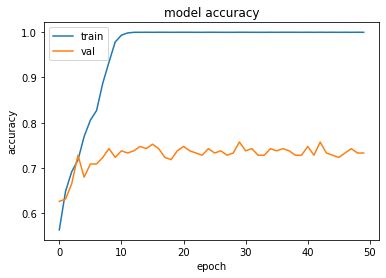

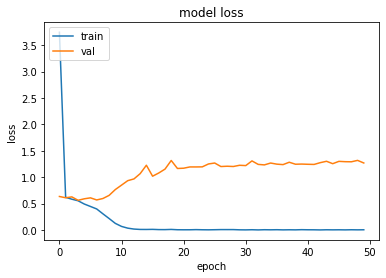

Folder num 6
Genre split [['Hip-Hop', 'International', 'Pop', 'Rock'], ['Folk', 'Electronic', 'Instrumental', 'Experimental']]
Building model...
Training...
Epoch 1/50
110/110 [==============================] - 20s 173ms/step - loss: 3.2632 - accuracy: 0.5904 - val_loss: 0.6350 - val_accuracy: 0.6796

Epoch 00001: val_accuracy improved from -inf to 0.67961, saving model to ./models/tree_5/model_root/folder6\model.h5
Epoch 2/50
110/110 [==============================] - 19s 172ms/step - loss: 0.5701 - accuracy: 0.7108 - val_loss: 0.6256 - val_accuracy: 0.6456

Epoch 00002: val_accuracy did not improve from 0.67961
Epoch 3/50
110/110 [==============================] - 19s 170ms/step - loss: 0.5383 - accuracy: 0.7380 - val_loss: 0.6406 - val_accuracy: 0.6456

Epoch 00003: val_accuracy did not improve from 0.67961
Epoch 4/50
110/110 [==============================] - 19s 169ms/step - loss: 0.5006 - accuracy: 0.7639 - val_loss: 0.6126 - val_accuracy: 0.7136

Epoch 00004: val_accuracy improv

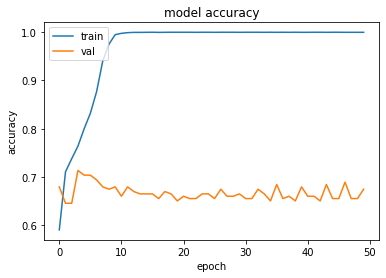

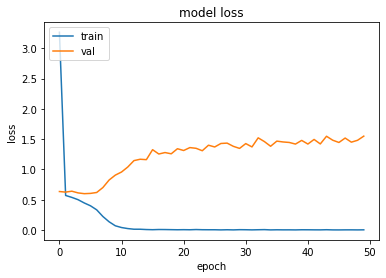

Folder num 7
Genre split [['Pop', 'Electronic', 'Rock', 'Instrumental'], ['Experimental', 'International', 'Hip-Hop', 'Folk']]
Building model...
Training...
Epoch 1/50
110/110 [==============================] - 27s 231ms/step - loss: 5.0259 - accuracy: 0.5325 - val_loss: 0.6641 - val_accuracy: 0.6068

Epoch 00001: val_accuracy improved from -inf to 0.60680, saving model to ./models/tree_5/model_root/folder7\model.h5
Epoch 2/50
110/110 [==============================] - 19s 171ms/step - loss: 0.6278 - accuracy: 0.6584 - val_loss: 0.6251 - val_accuracy: 0.6845

Epoch 00002: val_accuracy improved from 0.60680 to 0.68447, saving model to ./models/tree_5/model_root/folder7\model.h5
Epoch 3/50
110/110 [==============================] - 19s 171ms/step - loss: 0.5861 - accuracy: 0.6999 - val_loss: 0.5826 - val_accuracy: 0.7184

Epoch 00003: val_accuracy improved from 0.68447 to 0.71845, saving model to ./models/tree_5/model_root/folder7\model.h5
Epoch 4/50
110/110 [============================

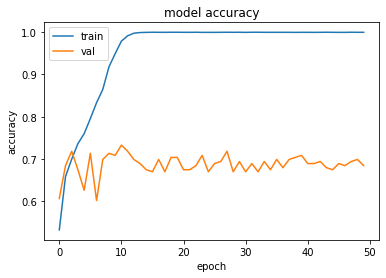

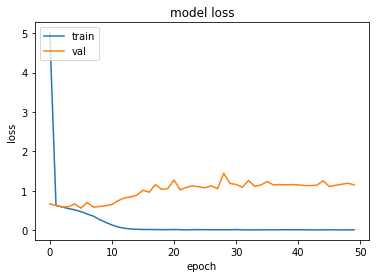

Folder num 8
Genre split [['Pop', 'Rock', 'Instrumental', 'Folk'], ['Electronic', 'Hip-Hop', 'International', 'Experimental']]
Building model...
Training...
Epoch 1/50
110/110 [==============================] - 20s 173ms/step - loss: 3.2752 - accuracy: 0.6156 - val_loss: 0.5786 - val_accuracy: 0.6845

Epoch 00001: val_accuracy improved from -inf to 0.68447, saving model to ./models/tree_5/model_root/folder8\model.h5
Epoch 2/50
110/110 [==============================] - 19s 176ms/step - loss: 0.5402 - accuracy: 0.7434 - val_loss: 0.5544 - val_accuracy: 0.7330

Epoch 00002: val_accuracy improved from 0.68447 to 0.73301, saving model to ./models/tree_5/model_root/folder8\model.h5
Epoch 3/50
110/110 [==============================] - 19s 176ms/step - loss: 0.4996 - accuracy: 0.7713 - val_loss: 0.5178 - val_accuracy: 0.7718

Epoch 00003: val_accuracy improved from 0.73301 to 0.77184, saving model to ./models/tree_5/model_root/folder8\model.h5
Epoch 4/50
110/110 [============================

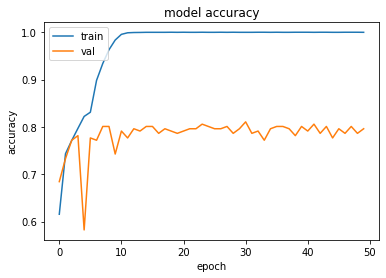

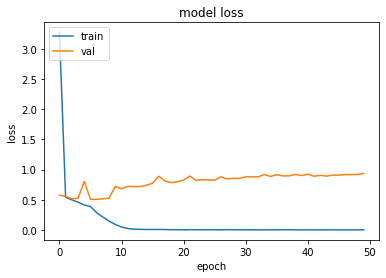

Folder num 9
Genre split [['Folk', 'International', 'Rock', 'Hip-Hop'], ['Electronic', 'Pop', 'Experimental', 'Instrumental']]
Building model...
Training...
Epoch 1/50
110/110 [==============================] - 24s 179ms/step - loss: 2.1284 - accuracy: 0.5799 - val_loss: 0.5752 - val_accuracy: 0.7039

Epoch 00001: val_accuracy improved from -inf to 0.70388, saving model to ./models/tree_5/model_root/folder9\model.h5
Epoch 2/50
110/110 [==============================] - 19s 169ms/step - loss: 0.6034 - accuracy: 0.6676 - val_loss: 0.6542 - val_accuracy: 0.6019

Epoch 00002: val_accuracy did not improve from 0.70388
Epoch 3/50
110/110 [==============================] - 19s 169ms/step - loss: 0.5354 - accuracy: 0.7393 - val_loss: 0.5566 - val_accuracy: 0.7039

Epoch 00003: val_accuracy did not improve from 0.70388
Epoch 4/50
110/110 [==============================] - 19s 170ms/step - loss: 0.4798 - accuracy: 0.7789 - val_loss: 0.5856 - val_accuracy: 0.6893

Epoch 00004: val_accuracy did no

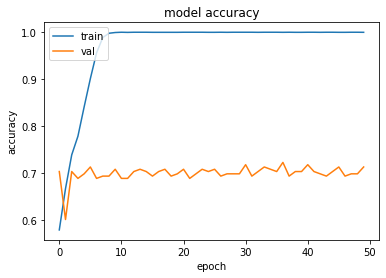

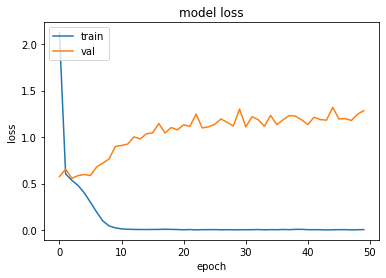

Folder num 10
Genre split [['Rock', 'Instrumental', 'Folk', 'Pop'], ['Experimental', 'Electronic', 'Hip-Hop', 'International']]
Building model...
Training...
Epoch 1/50
110/110 [==============================] - 21s 178ms/step - loss: 3.9317 - accuracy: 0.6258 - val_loss: 0.6856 - val_accuracy: 0.6165

Epoch 00001: val_accuracy improved from -inf to 0.61650, saving model to ./models/tree_5/model_root/folder10\model.h5
Epoch 2/50
110/110 [==============================] - 19s 170ms/step - loss: 0.5423 - accuracy: 0.7418 - val_loss: 0.5177 - val_accuracy: 0.8010

Epoch 00002: val_accuracy improved from 0.61650 to 0.80097, saving model to ./models/tree_5/model_root/folder10\model.h5
Epoch 3/50
110/110 [==============================] - 19s 170ms/step - loss: 0.5095 - accuracy: 0.7637 - val_loss: 0.5297 - val_accuracy: 0.7718

Epoch 00003: val_accuracy did not improve from 0.80097
Epoch 4/50
110/110 [==============================] - 19s 169ms/step - loss: 0.4608 - accuracy: 0.7992 - val_l

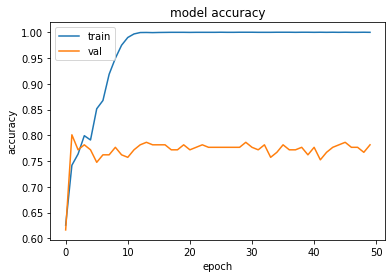

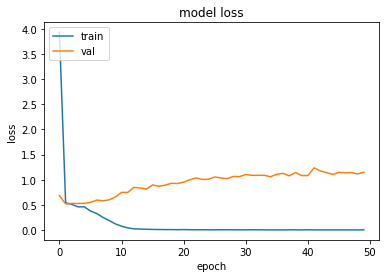

Folder num 11
Genre split [['Hip-Hop', 'Experimental', 'Folk', 'Pop'], ['International', 'Electronic', 'Rock', 'Instrumental']]
Building model...
Training...
Epoch 1/50
110/110 [==============================] - 21s 173ms/step - loss: 2.8333 - accuracy: 0.5336 - val_loss: 0.6838 - val_accuracy: 0.5437

Epoch 00001: val_accuracy improved from -inf to 0.54369, saving model to ./models/tree_5/model_root/folder11\model.h5
Epoch 2/50
110/110 [==============================] - 20s 179ms/step - loss: 0.6566 - accuracy: 0.6075 - val_loss: 0.6908 - val_accuracy: 0.5485

Epoch 00002: val_accuracy improved from 0.54369 to 0.54854, saving model to ./models/tree_5/model_root/folder11\model.h5
Epoch 3/50
110/110 [==============================] - 19s 177ms/step - loss: 0.6133 - accuracy: 0.6653 - val_loss: 0.6571 - val_accuracy: 0.6214

Epoch 00003: val_accuracy improved from 0.54854 to 0.62136, saving model to ./models/tree_5/model_root/folder11\model.h5
Epoch 4/50
110/110 [========================

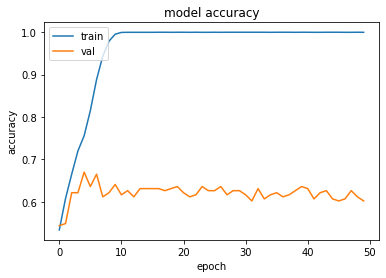

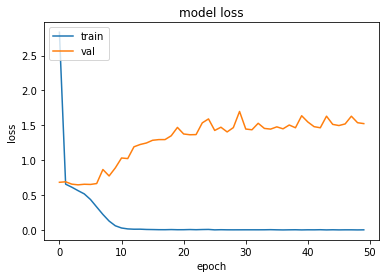

Folder num 12
Genre split [['Instrumental', 'Experimental', 'Rock', 'Hip-Hop'], ['Electronic', 'Folk', 'International', 'Pop']]
Building model...
Training...
Epoch 1/50
110/110 [==============================] - 21s 172ms/step - loss: 1.9948 - accuracy: 0.5969 - val_loss: 0.6513 - val_accuracy: 0.6019

Epoch 00001: val_accuracy improved from -inf to 0.60194, saving model to ./models/tree_5/model_root/folder12\model.h5
Epoch 2/50
110/110 [==============================] - 18s 168ms/step - loss: 0.6039 - accuracy: 0.6793 - val_loss: 0.6402 - val_accuracy: 0.6262

Epoch 00002: val_accuracy improved from 0.60194 to 0.62621, saving model to ./models/tree_5/model_root/folder12\model.h5
Epoch 3/50
110/110 [==============================] - 19s 170ms/step - loss: 0.5724 - accuracy: 0.7001 - val_loss: 0.6512 - val_accuracy: 0.6456

Epoch 00003: val_accuracy improved from 0.62621 to 0.64563, saving model to ./models/tree_5/model_root/folder12\model.h5
Epoch 4/50
110/110 [========================

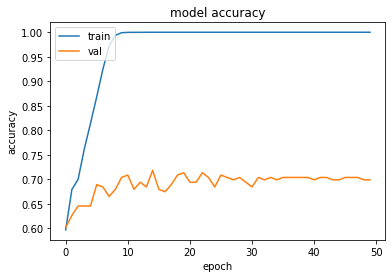

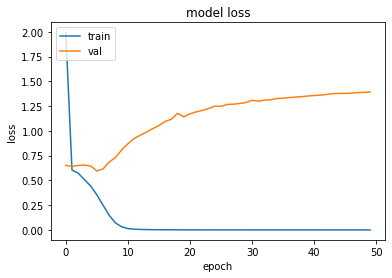

Folder num 13
Genre split [['Rock', 'Folk', 'Pop', 'Hip-Hop'], ['Electronic', 'Experimental', 'International', 'Instrumental']]
Building model...
Training...
Epoch 1/50
110/110 [==============================] - 20s 172ms/step - loss: 2.0859 - accuracy: 0.5896 - val_loss: 0.7063 - val_accuracy: 0.5971

Epoch 00001: val_accuracy improved from -inf to 0.59709, saving model to ./models/tree_5/model_root/folder13\model.h5
Epoch 2/50
110/110 [==============================] - 19s 169ms/step - loss: 0.5956 - accuracy: 0.6840 - val_loss: 0.6140 - val_accuracy: 0.6845

Epoch 00002: val_accuracy improved from 0.59709 to 0.68447, saving model to ./models/tree_5/model_root/folder13\model.h5
Epoch 3/50
110/110 [==============================] - 19s 169ms/step - loss: 0.5392 - accuracy: 0.7397 - val_loss: 0.6272 - val_accuracy: 0.6602

Epoch 00003: val_accuracy did not improve from 0.68447
Epoch 4/50
110/110 [==============================] - 19s 169ms/step - loss: 0.4876 - accuracy: 0.7715 - val_l

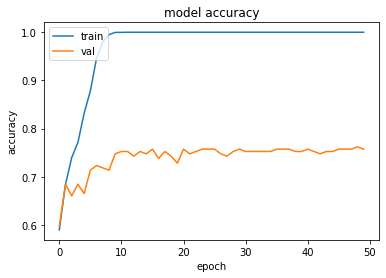

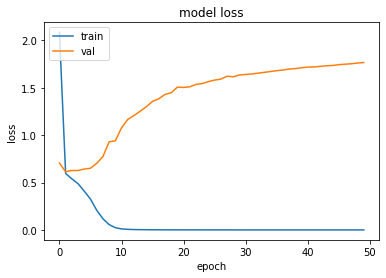

Folder num 14
Genre split [['Electronic', 'Rock', 'Instrumental', 'Experimental'], ['Folk', 'International', 'Pop', 'Hip-Hop']]
Building model...
Training...
Epoch 1/50
110/110 [==============================] - 20s 172ms/step - loss: 2.8058 - accuracy: 0.5841 - val_loss: 0.6308 - val_accuracy: 0.6942

Epoch 00001: val_accuracy improved from -inf to 0.69417, saving model to ./models/tree_5/model_root/folder14\model.h5
Epoch 2/50
110/110 [==============================] - 19s 169ms/step - loss: 0.5826 - accuracy: 0.6940 - val_loss: 0.6284 - val_accuracy: 0.6408

Epoch 00002: val_accuracy did not improve from 0.69417
Epoch 3/50
110/110 [==============================] - 19s 169ms/step - loss: 0.5466 - accuracy: 0.7179 - val_loss: 0.7102 - val_accuracy: 0.5922

Epoch 00003: val_accuracy did not improve from 0.69417
Epoch 4/50
110/110 [==============================] - 19s 170ms/step - loss: 0.5021 - accuracy: 0.7553 - val_loss: 0.5197 - val_accuracy: 0.7524

Epoch 00004: val_accuracy impr

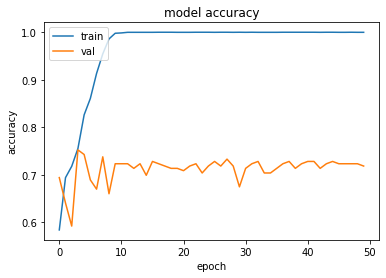

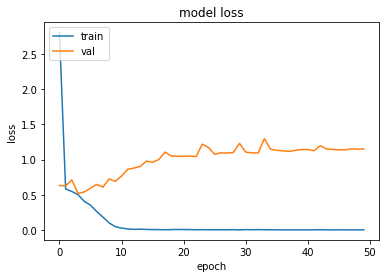

Folder num 15
Genre split [['International', 'Instrumental', 'Folk', 'Hip-Hop'], ['Pop', 'Electronic', 'Rock', 'Experimental']]
Building model...
Training...
Epoch 1/50
110/110 [==============================] - 24s 193ms/step - loss: 3.9846 - accuracy: 0.5750 - val_loss: 0.5780 - val_accuracy: 0.6893

Epoch 00001: val_accuracy improved from -inf to 0.68932, saving model to ./models/tree_5/model_root/folder15\model.h5
Epoch 2/50
110/110 [==============================] - 19s 175ms/step - loss: 0.6008 - accuracy: 0.6799 - val_loss: 0.5818 - val_accuracy: 0.6990

Epoch 00002: val_accuracy improved from 0.68932 to 0.69903, saving model to ./models/tree_5/model_root/folder15\model.h5
Epoch 3/50
110/110 [==============================] - 20s 179ms/step - loss: 0.5840 - accuracy: 0.6955 - val_loss: 0.6206 - val_accuracy: 0.6602

Epoch 00003: val_accuracy did not improve from 0.69903
Epoch 4/50
110/110 [==============================] - 19s 171ms/step - loss: 0.5526 - accuracy: 0.7275 - val_l

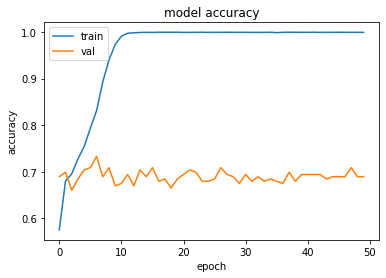

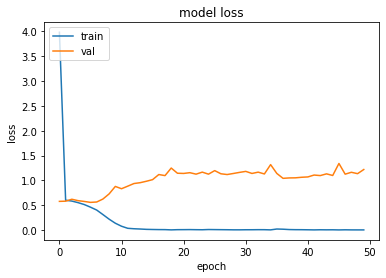

Folder num 16
Genre split [['Pop', 'Hip-Hop', 'Instrumental', 'Electronic'], ['Rock', 'Folk', 'Experimental', 'International']]
Building model...
Training...
Epoch 1/50
110/110 [==============================] - 20s 172ms/step - loss: 2.4162 - accuracy: 0.5565 - val_loss: 0.6366 - val_accuracy: 0.6117

Epoch 00001: val_accuracy improved from -inf to 0.61165, saving model to ./models/tree_5/model_root/folder16\model.h5
Epoch 2/50
110/110 [==============================] - 19s 168ms/step - loss: 0.6134 - accuracy: 0.6684 - val_loss: 0.7492 - val_accuracy: 0.5485

Epoch 00002: val_accuracy did not improve from 0.61165
Epoch 3/50
110/110 [==============================] - 19s 169ms/step - loss: 0.5567 - accuracy: 0.7195 - val_loss: 0.5714 - val_accuracy: 0.6990

Epoch 00003: val_accuracy improved from 0.61165 to 0.69903, saving model to ./models/tree_5/model_root/folder16\model.h5
Epoch 4/50
110/110 [==============================] - 19s 169ms/step - loss: 0.4956 - accuracy: 0.7656 - val_l

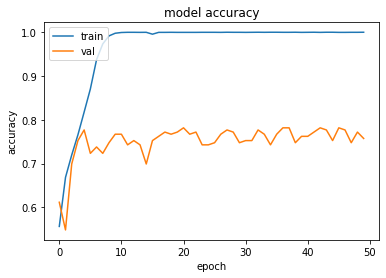

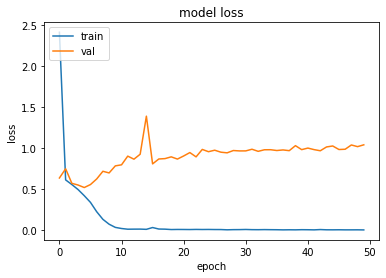

Folder num 17
Genre split [['Hip-Hop', 'Instrumental', 'International', 'Rock'], ['Pop', 'Experimental', 'Folk', 'Electronic']]
Building model...
Training...
Epoch 1/50
110/110 [==============================] - 24s 195ms/step - loss: 4.6619 - accuracy: 0.5124 - val_loss: 0.7211 - val_accuracy: 0.4806

Epoch 00001: val_accuracy improved from -inf to 0.48058, saving model to ./models/tree_5/model_root/folder17\model.h5
Epoch 2/50
110/110 [==============================] - 19s 170ms/step - loss: 0.6764 - accuracy: 0.5683 - val_loss: 0.6907 - val_accuracy: 0.5485

Epoch 00002: val_accuracy improved from 0.48058 to 0.54854, saving model to ./models/tree_5/model_root/folder17\model.h5
Epoch 3/50
110/110 [==============================] - 19s 169ms/step - loss: 0.6466 - accuracy: 0.6314 - val_loss: 0.6782 - val_accuracy: 0.5874

Epoch 00003: val_accuracy improved from 0.54854 to 0.58738, saving model to ./models/tree_5/model_root/folder17\model.h5
Epoch 4/50
110/110 [========================

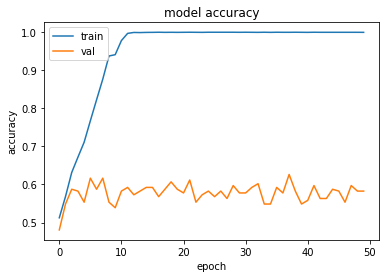

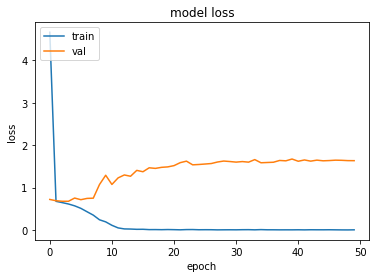

Folder num 18
Genre split [['Instrumental', 'Experimental', 'Rock', 'Hip-Hop'], ['Pop', 'Folk', 'International', 'Electronic']]
Building model...
Training...
Epoch 1/50
110/110 [==============================] - 21s 183ms/step - loss: 1.9411 - accuracy: 0.5824 - val_loss: 0.6673 - val_accuracy: 0.5777

Epoch 00001: val_accuracy improved from -inf to 0.57767, saving model to ./models/tree_5/model_root/folder18\model.h5
Epoch 2/50
110/110 [==============================] - 18s 168ms/step - loss: 0.6145 - accuracy: 0.6653 - val_loss: 0.6275 - val_accuracy: 0.6602

Epoch 00002: val_accuracy improved from 0.57767 to 0.66019, saving model to ./models/tree_5/model_root/folder18\model.h5
Epoch 3/50
110/110 [==============================] - 19s 169ms/step - loss: 0.5758 - accuracy: 0.7013 - val_loss: 0.6203 - val_accuracy: 0.6311

Epoch 00003: val_accuracy did not improve from 0.66019
Epoch 4/50
110/110 [==============================] - 19s 170ms/step - loss: 0.5398 - accuracy: 0.7334 - val_l

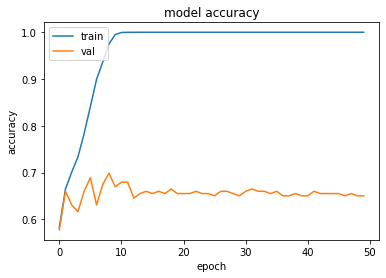

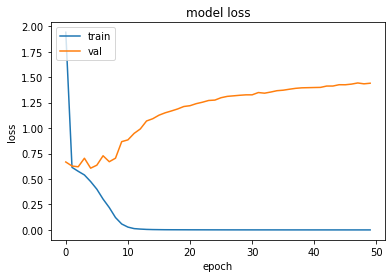

Folder num 19
Genre split [['Rock', 'Folk', 'Instrumental', 'Pop'], ['Hip-Hop', 'Electronic', 'International', 'Experimental']]
Building model...
Training...
Epoch 1/50
110/110 [==============================] - 22s 185ms/step - loss: 3.0963 - accuracy: 0.6029 - val_loss: 0.5971 - val_accuracy: 0.6796

Epoch 00001: val_accuracy improved from -inf to 0.67961, saving model to ./models/tree_5/model_root/folder19\model.h5
Epoch 2/50
110/110 [==============================] - 19s 170ms/step - loss: 0.5610 - accuracy: 0.7297 - val_loss: 0.5973 - val_accuracy: 0.6796

Epoch 00002: val_accuracy did not improve from 0.67961
Epoch 3/50
110/110 [==============================] - 19s 169ms/step - loss: 0.5039 - accuracy: 0.7732 - val_loss: 0.5697 - val_accuracy: 0.7233

Epoch 00003: val_accuracy improved from 0.67961 to 0.72330, saving model to ./models/tree_5/model_root/folder19\model.h5
Epoch 4/50
110/110 [==============================] - 19s 169ms/step - loss: 0.4613 - accuracy: 0.7955 - val_l

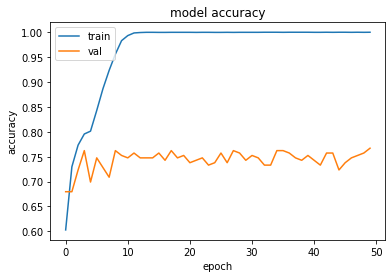

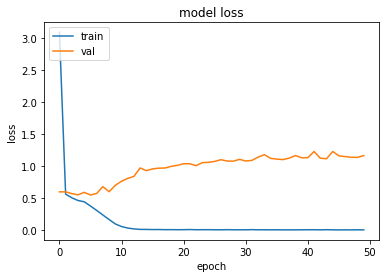

Folder num 20
Genre split [['International', 'Instrumental', 'Experimental', 'Hip-Hop'], ['Rock', 'Folk', 'Electronic', 'Pop']]
Building model...
Training...
Epoch 1/50
110/110 [==============================] - 24s 187ms/step - loss: 2.1529 - accuracy: 0.5656 - val_loss: 0.6848 - val_accuracy: 0.5854

Epoch 00001: val_accuracy improved from -inf to 0.58537, saving model to ./models/tree_5/model_root/folder20\model.h5
Epoch 2/50
110/110 [==============================] - 19s 173ms/step - loss: 0.6290 - accuracy: 0.6543 - val_loss: 0.6563 - val_accuracy: 0.6439

Epoch 00002: val_accuracy improved from 0.58537 to 0.64390, saving model to ./models/tree_5/model_root/folder20\model.h5
Epoch 3/50
110/110 [==============================] - 19s 171ms/step - loss: 0.5723 - accuracy: 0.7088 - val_loss: 1.0357 - val_accuracy: 0.4976

Epoch 00003: val_accuracy did not improve from 0.64390
Epoch 4/50
110/110 [==============================] - 19s 170ms/step - loss: 0.5428 - accuracy: 0.7283 - val_l

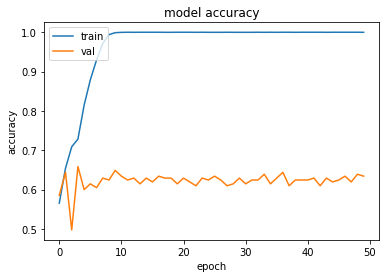

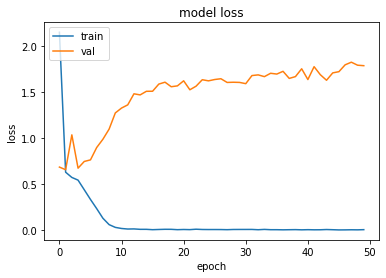

Folder num 21
Genre split [['Folk', 'Rock', 'Hip-Hop', 'International'], ['Electronic', 'Pop', 'Experimental', 'Instrumental']]
Building model...
Training...
Epoch 1/50
110/110 [==============================] - 21s 182ms/step - loss: 3.0394 - accuracy: 0.5700 - val_loss: 0.6536 - val_accuracy: 0.6439

Epoch 00001: val_accuracy improved from -inf to 0.64390, saving model to ./models/tree_5/model_root/folder21\model.h5
Epoch 2/50
110/110 [==============================] - 19s 170ms/step - loss: 0.5994 - accuracy: 0.6815 - val_loss: 0.6408 - val_accuracy: 0.6488

Epoch 00002: val_accuracy improved from 0.64390 to 0.64878, saving model to ./models/tree_5/model_root/folder21\model.h5
Epoch 3/50
110/110 [==============================] - 19s 171ms/step - loss: 0.5574 - accuracy: 0.7224 - val_loss: 0.6360 - val_accuracy: 0.6585

Epoch 00003: val_accuracy improved from 0.64878 to 0.65854, saving model to ./models/tree_5/model_root/folder21\model.h5
Epoch 4/50
110/110 [========================

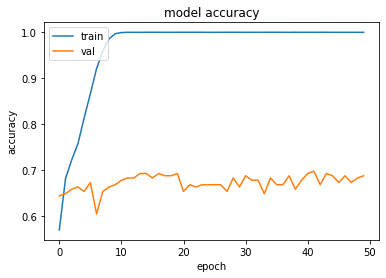

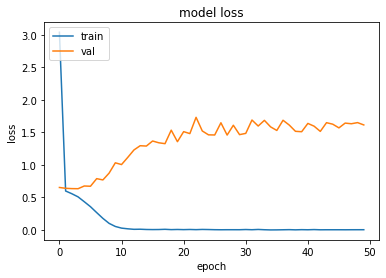

Folder num 22
Genre split [['Hip-Hop', 'Electronic', 'Rock', 'Instrumental'], ['Experimental', 'Pop', 'International', 'Folk']]
Building model...
Training...
Epoch 1/50
110/110 [==============================] - 23s 174ms/step - loss: 2.9266 - accuracy: 0.5527 - val_loss: 0.6262 - val_accuracy: 0.6537

Epoch 00001: val_accuracy improved from -inf to 0.65366, saving model to ./models/tree_5/model_root/folder22\model.h5
Epoch 2/50
110/110 [==============================] - 19s 169ms/step - loss: 0.6247 - accuracy: 0.6530 - val_loss: 0.6026 - val_accuracy: 0.6976

Epoch 00002: val_accuracy improved from 0.65366 to 0.69756, saving model to ./models/tree_5/model_root/folder22\model.h5
Epoch 3/50
110/110 [==============================] - 19s 169ms/step - loss: 0.5844 - accuracy: 0.6927 - val_loss: 0.6057 - val_accuracy: 0.6537

Epoch 00003: val_accuracy did not improve from 0.69756
Epoch 4/50
110/110 [==============================] - 19s 169ms/step - loss: 0.5459 - accuracy: 0.7201 - val_l

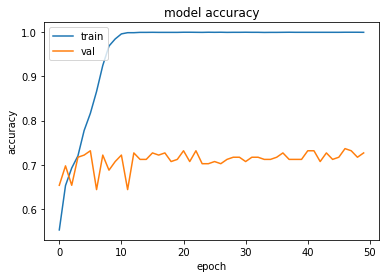

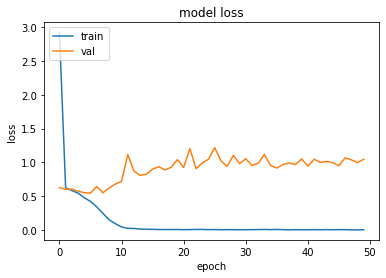

Folder num 23
Genre split [['Hip-Hop', 'International', 'Rock', 'Electronic'], ['Instrumental', 'Pop', 'Experimental', 'Folk']]
Building model...
Training...
Epoch 1/50
110/110 [==============================] - 22s 181ms/step - loss: 3.4280 - accuracy: 0.6065 - val_loss: 0.6110 - val_accuracy: 0.6439

Epoch 00001: val_accuracy improved from -inf to 0.64390, saving model to ./models/tree_5/model_root/folder23\model.h5
Epoch 2/50
110/110 [==============================] - 19s 169ms/step - loss: 0.5584 - accuracy: 0.7221 - val_loss: 0.5198 - val_accuracy: 0.7415

Epoch 00002: val_accuracy improved from 0.64390 to 0.74146, saving model to ./models/tree_5/model_root/folder23\model.h5
Epoch 3/50
110/110 [==============================] - 19s 169ms/step - loss: 0.5215 - accuracy: 0.7483 - val_loss: 0.5795 - val_accuracy: 0.7024

Epoch 00003: val_accuracy did not improve from 0.74146
Epoch 4/50
110/110 [==============================] - 19s 169ms/step - loss: 0.4913 - accuracy: 0.7668 - val_l

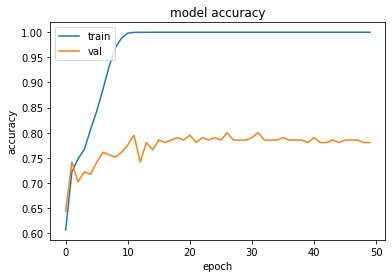

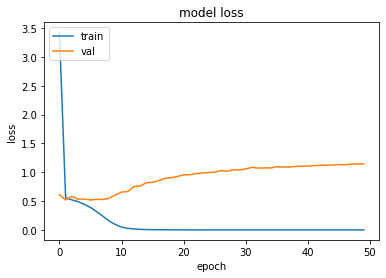

Folder num 24
Genre split [['International', 'Instrumental', 'Experimental', 'Pop'], ['Electronic', 'Hip-Hop', 'Rock', 'Folk']]
Building model...
Training...
Epoch 1/50
110/110 [==============================] - 21s 172ms/step - loss: 4.6965 - accuracy: 0.5579 - val_loss: 0.6376 - val_accuracy: 0.5902

Epoch 00001: val_accuracy improved from -inf to 0.59024, saving model to ./models/tree_5/model_root/folder24\model.h5
Epoch 2/50
110/110 [==============================] - 21s 193ms/step - loss: 0.6283 - accuracy: 0.6460 - val_loss: 0.6321 - val_accuracy: 0.6195

Epoch 00002: val_accuracy improved from 0.59024 to 0.61951, saving model to ./models/tree_5/model_root/folder24\model.h5
Epoch 3/50
110/110 [==============================] - 19s 170ms/step - loss: 0.6113 - accuracy: 0.6698 - val_loss: 0.6246 - val_accuracy: 0.6195

Epoch 00003: val_accuracy did not improve from 0.61951
Epoch 4/50
110/110 [==============================] - 18s 168ms/step - loss: 0.5834 - accuracy: 0.6961 - val_l

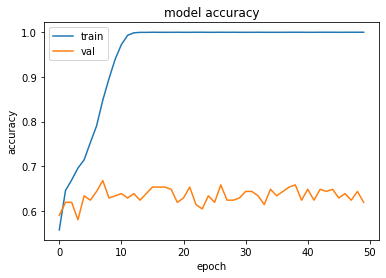

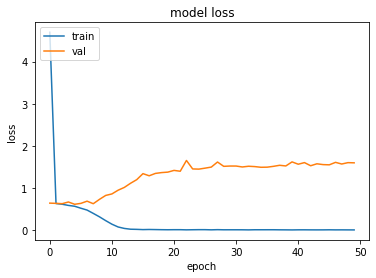

Folder num 25
Genre split [['Electronic', 'Pop', 'Experimental', 'Instrumental'], ['Hip-Hop', 'Rock', 'International', 'Folk']]
Building model...
Training...
Epoch 1/50
110/110 [==============================] - 20s 172ms/step - loss: 2.1229 - accuracy: 0.5843 - val_loss: 0.6018 - val_accuracy: 0.6390

Epoch 00001: val_accuracy improved from -inf to 0.63902, saving model to ./models/tree_5/model_root/folder25\model.h5
Epoch 2/50
110/110 [==============================] - 19s 169ms/step - loss: 0.6108 - accuracy: 0.6625 - val_loss: 0.5405 - val_accuracy: 0.7122

Epoch 00002: val_accuracy improved from 0.63902 to 0.71220, saving model to ./models/tree_5/model_root/folder25\model.h5
Epoch 3/50
110/110 [==============================] - 19s 169ms/step - loss: 0.5650 - accuracy: 0.7104 - val_loss: 0.5960 - val_accuracy: 0.6683

Epoch 00003: val_accuracy did not improve from 0.71220
Epoch 4/50
110/110 [==============================] - 19s 169ms/step - loss: 0.5114 - accuracy: 0.7470 - val_l

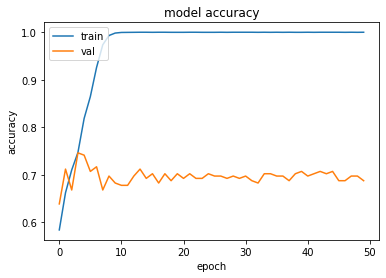

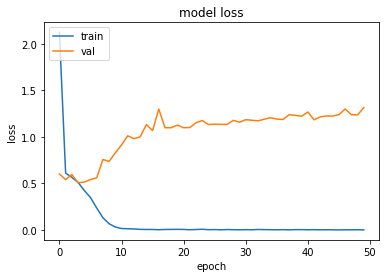

Folder num 26
Genre split [['Experimental', 'International', 'Hip-Hop', 'Pop'], ['Instrumental', 'Folk', 'Rock', 'Electronic']]
Building model...
Training...
Epoch 1/50
110/110 [==============================] - 22s 187ms/step - loss: 3.7992 - accuracy: 0.5703 - val_loss: 0.6393 - val_accuracy: 0.6585

Epoch 00001: val_accuracy improved from -inf to 0.65854, saving model to ./models/tree_5/model_root/folder26\model.h5
Epoch 2/50
110/110 [==============================] - 19s 170ms/step - loss: 0.6108 - accuracy: 0.6752 - val_loss: 0.6375 - val_accuracy: 0.6634

Epoch 00002: val_accuracy improved from 0.65854 to 0.66341, saving model to ./models/tree_5/model_root/folder26\model.h5
Epoch 3/50
110/110 [==============================] - 19s 170ms/step - loss: 0.5804 - accuracy: 0.6998 - val_loss: 0.6155 - val_accuracy: 0.6683

Epoch 00003: val_accuracy improved from 0.66341 to 0.66829, saving model to ./models/tree_5/model_root/folder26\model.h5
Epoch 4/50
110/110 [========================

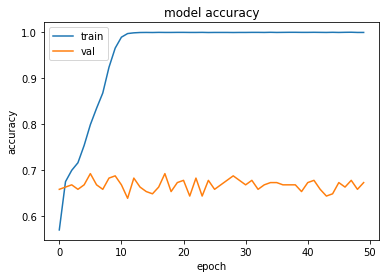

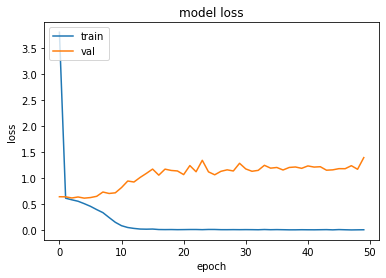

Folder num 27
Genre split [['Experimental', 'Electronic', 'Hip-Hop', 'Pop'], ['Rock', 'Folk', 'Instrumental', 'International']]
Building model...
Training...
Epoch 1/50
110/110 [==============================] - 20s 172ms/step - loss: 1.9736 - accuracy: 0.6158 - val_loss: 0.5732 - val_accuracy: 0.6878

Epoch 00001: val_accuracy improved from -inf to 0.68780, saving model to ./models/tree_5/model_root/folder27\model.h5
Epoch 2/50
110/110 [==============================] - 19s 169ms/step - loss: 0.5865 - accuracy: 0.6925 - val_loss: 0.5108 - val_accuracy: 0.7805

Epoch 00002: val_accuracy improved from 0.68780 to 0.78049, saving model to ./models/tree_5/model_root/folder27\model.h5
Epoch 3/50
110/110 [==============================] - 19s 169ms/step - loss: 0.5348 - accuracy: 0.7396 - val_loss: 0.5150 - val_accuracy: 0.7707

Epoch 00003: val_accuracy did not improve from 0.78049
Epoch 4/50
110/110 [==============================] - 19s 170ms/step - loss: 0.4695 - accuracy: 0.7845 - val_l

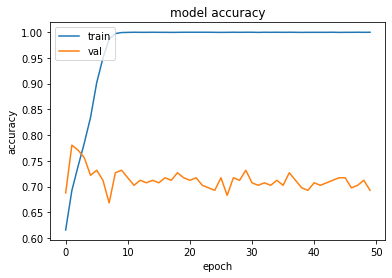

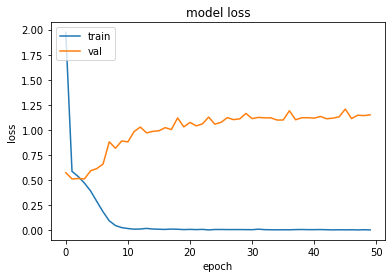

Folder num 28
Genre split [['Hip-Hop', 'International', 'Electronic', 'Instrumental'], ['Folk', 'Rock', 'Pop', 'Experimental']]
Building model...
Training...
Epoch 1/50
110/110 [==============================] - 21s 173ms/step - loss: 2.1097 - accuracy: 0.6038 - val_loss: 0.6812 - val_accuracy: 0.6390

Epoch 00001: val_accuracy improved from -inf to 0.63902, saving model to ./models/tree_5/model_root/folder28\model.h5
Epoch 2/50
110/110 [==============================] - 19s 172ms/step - loss: 0.5751 - accuracy: 0.7134 - val_loss: 0.5756 - val_accuracy: 0.6927

Epoch 00002: val_accuracy improved from 0.63902 to 0.69268, saving model to ./models/tree_5/model_root/folder28\model.h5
Epoch 3/50
110/110 [==============================] - 19s 170ms/step - loss: 0.5261 - accuracy: 0.7412 - val_loss: 0.5502 - val_accuracy: 0.7415

Epoch 00003: val_accuracy improved from 0.69268 to 0.74146, saving model to ./models/tree_5/model_root/folder28\model.h5
Epoch 4/50
110/110 [========================

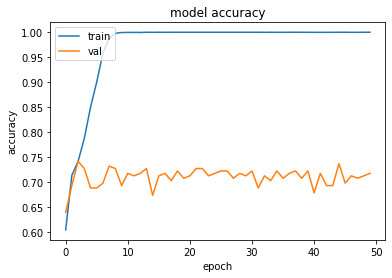

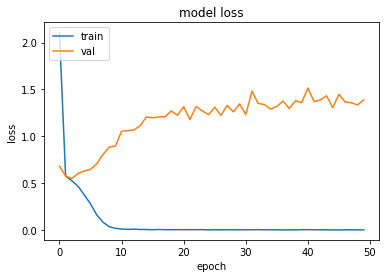

Folder num 29
Genre split [['Rock', 'International', 'Pop', 'Electronic'], ['Hip-Hop', 'Folk', 'Instrumental', 'Experimental']]
Building model...
Training...
Epoch 1/50
110/110 [==============================] - 22s 187ms/step - loss: 2.7220 - accuracy: 0.5842 - val_loss: 0.5835 - val_accuracy: 0.6878

Epoch 00001: val_accuracy improved from -inf to 0.68780, saving model to ./models/tree_5/model_root/folder29\model.h5
Epoch 2/50
110/110 [==============================] - 19s 169ms/step - loss: 0.6062 - accuracy: 0.6678 - val_loss: 0.5645 - val_accuracy: 0.7268

Epoch 00002: val_accuracy improved from 0.68780 to 0.72683, saving model to ./models/tree_5/model_root/folder29\model.h5
Epoch 3/50
110/110 [==============================] - 19s 169ms/step - loss: 0.5596 - accuracy: 0.7166 - val_loss: 0.6598 - val_accuracy: 0.6146

Epoch 00003: val_accuracy did not improve from 0.72683
Epoch 4/50
110/110 [==============================] - 19s 168ms/step - loss: 0.5146 - accuracy: 0.7579 - val_l

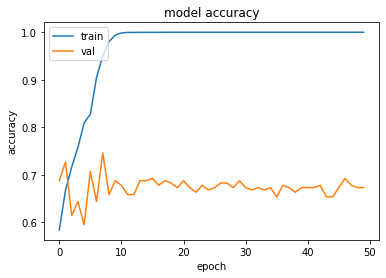

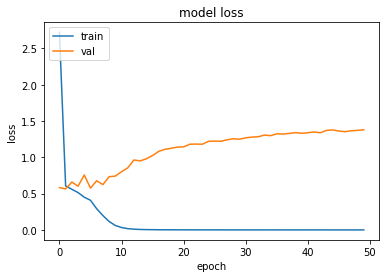

Folder num 30
Genre split [['Hip-Hop', 'Pop', 'Experimental', 'Rock'], ['International', 'Electronic', 'Instrumental', 'Folk']]
Building model...
Training...
Epoch 1/50
110/110 [==============================] - 21s 173ms/step - loss: 2.9964 - accuracy: 0.5855 - val_loss: 0.5540 - val_accuracy: 0.7024

Epoch 00001: val_accuracy improved from -inf to 0.70244, saving model to ./models/tree_5/model_root/folder30\model.h5
Epoch 2/50
110/110 [==============================] - 19s 169ms/step - loss: 0.5826 - accuracy: 0.6997 - val_loss: 0.6706 - val_accuracy: 0.5854

Epoch 00002: val_accuracy did not improve from 0.70244
Epoch 3/50
110/110 [==============================] - 19s 174ms/step - loss: 0.5479 - accuracy: 0.7237 - val_loss: 0.5524 - val_accuracy: 0.7463

Epoch 00003: val_accuracy improved from 0.70244 to 0.74634, saving model to ./models/tree_5/model_root/folder30\model.h5
Epoch 4/50
110/110 [==============================] - 19s 170ms/step - loss: 0.5048 - accuracy: 0.7599 - val_l

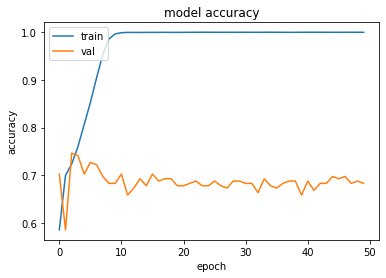

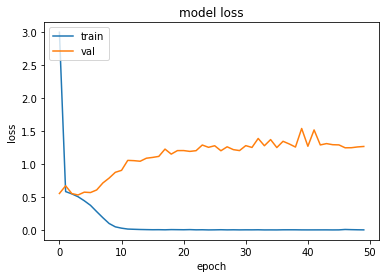

Folder num 31
Genre split [['Experimental', 'Electronic', 'International', 'Hip-Hop'], ['Pop', 'Folk', 'Rock', 'Instrumental']]
Building model...
Training...
Epoch 1/50
110/110 [==============================] - 20s 173ms/step - loss: 3.1626 - accuracy: 0.6074 - val_loss: 0.5197 - val_accuracy: 0.7854

Epoch 00001: val_accuracy improved from -inf to 0.78537, saving model to ./models/tree_5/model_root/folder31\model.h5
Epoch 2/50
110/110 [==============================] - 19s 169ms/step - loss: 0.5372 - accuracy: 0.7330 - val_loss: 0.4742 - val_accuracy: 0.7951

Epoch 00002: val_accuracy improved from 0.78537 to 0.79512, saving model to ./models/tree_5/model_root/folder31\model.h5
Epoch 3/50
110/110 [==============================] - 19s 169ms/step - loss: 0.4965 - accuracy: 0.7769 - val_loss: 0.4877 - val_accuracy: 0.7854

Epoch 00003: val_accuracy did not improve from 0.79512
Epoch 4/50
110/110 [==============================] - 20s 178ms/step - loss: 0.4825 - accuracy: 0.7808 - val_l

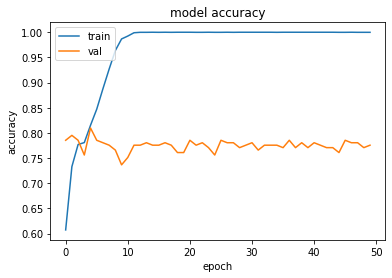

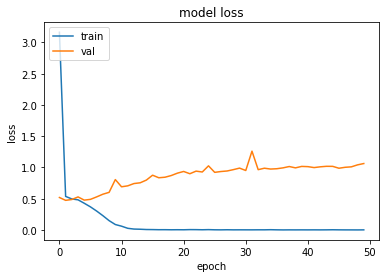

Folder num 32
Genre split [['Experimental', 'Instrumental', 'Electronic', 'Rock'], ['Hip-Hop', 'Folk', 'Pop', 'International']]
Building model...
Training...
Epoch 1/50
110/110 [==============================] - 21s 172ms/step - loss: 3.7126 - accuracy: 0.5845 - val_loss: 0.6063 - val_accuracy: 0.6927

Epoch 00001: val_accuracy improved from -inf to 0.69268, saving model to ./models/tree_5/model_root/folder32\model.h5
Epoch 2/50
110/110 [==============================] - 19s 169ms/step - loss: 0.5760 - accuracy: 0.7063 - val_loss: 0.5910 - val_accuracy: 0.6780

Epoch 00002: val_accuracy did not improve from 0.69268
Epoch 3/50
110/110 [==============================] - 19s 170ms/step - loss: 0.5376 - accuracy: 0.7340 - val_loss: 0.8300 - val_accuracy: 0.5561

Epoch 00003: val_accuracy did not improve from 0.69268
Epoch 4/50
110/110 [==============================] - 19s 170ms/step - loss: 0.5049 - accuracy: 0.7505 - val_loss: 0.6282 - val_accuracy: 0.6780

Epoch 00004: val_accuracy did 

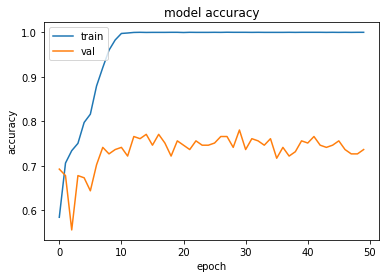

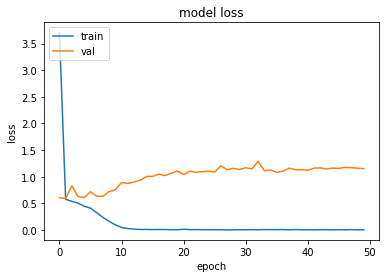

Folder num 33
Genre split [['Instrumental', 'International', 'Hip-Hop', 'Pop'], ['Rock', 'Electronic', 'Experimental', 'Folk']]
Building model...
Training...
Epoch 1/50
110/110 [==============================] - 25s 207ms/step - loss: 2.6367 - accuracy: 0.5506 - val_loss: 0.6799 - val_accuracy: 0.6049

Epoch 00001: val_accuracy improved from -inf to 0.60488, saving model to ./models/tree_5/model_root/folder33\model.h5
Epoch 2/50
110/110 [==============================] - 19s 177ms/step - loss: 0.6515 - accuracy: 0.6236 - val_loss: 0.6543 - val_accuracy: 0.6488

Epoch 00002: val_accuracy improved from 0.60488 to 0.64878, saving model to ./models/tree_5/model_root/folder33\model.h5
Epoch 3/50
110/110 [==============================] - 19s 175ms/step - loss: 0.6164 - accuracy: 0.6679 - val_loss: 0.6297 - val_accuracy: 0.6927

Epoch 00003: val_accuracy improved from 0.64878 to 0.69268, saving model to ./models/tree_5/model_root/folder33\model.h5
Epoch 4/50
110/110 [========================

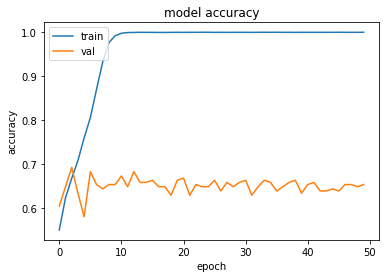

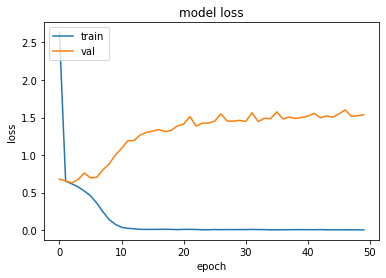

Folder num 34
Genre split [['Instrumental', 'International', 'Hip-Hop', 'Electronic'], ['Rock', 'Folk', 'Experimental', 'Pop']]
Building model...
Training...
Epoch 1/50
110/110 [==============================] - 21s 173ms/step - loss: 1.9422 - accuracy: 0.5828 - val_loss: 0.6098 - val_accuracy: 0.6341

Epoch 00001: val_accuracy improved from -inf to 0.63415, saving model to ./models/tree_5/model_root/folder34\model.h5
Epoch 2/50
110/110 [==============================] - 19s 170ms/step - loss: 0.5973 - accuracy: 0.6942 - val_loss: 0.6127 - val_accuracy: 0.7073

Epoch 00002: val_accuracy improved from 0.63415 to 0.70732, saving model to ./models/tree_5/model_root/folder34\model.h5
Epoch 3/50
110/110 [==============================] - 19s 170ms/step - loss: 0.5325 - accuracy: 0.7427 - val_loss: 0.5647 - val_accuracy: 0.6976

Epoch 00003: val_accuracy did not improve from 0.70732
Epoch 4/50
110/110 [==============================] - 19s 169ms/step - loss: 0.4865 - accuracy: 0.7752 - val_l

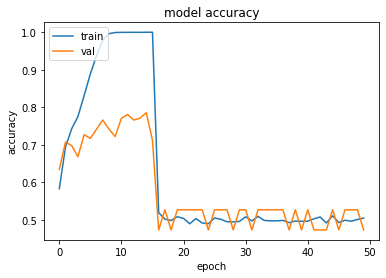

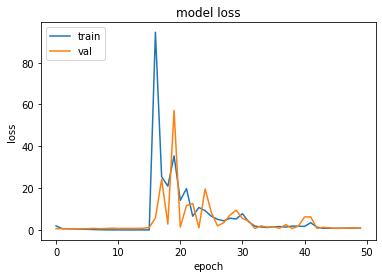

Folder num 35
Genre split [['Experimental', 'Pop', 'Folk', 'Electronic'], ['International', 'Hip-Hop', 'Rock', 'Instrumental']]
Building model...
Training...
Epoch 1/50
110/110 [==============================] - 24s 170ms/step - loss: 2.2203 - accuracy: 0.5091 - val_loss: 0.6857 - val_accuracy: 0.5073

Epoch 00001: val_accuracy improved from -inf to 0.50732, saving model to ./models/tree_5/model_root/folder35\model.h5
Epoch 2/50
110/110 [==============================] - 19s 169ms/step - loss: 0.6763 - accuracy: 0.5835 - val_loss: 0.8750 - val_accuracy: 0.5024

Epoch 00002: val_accuracy did not improve from 0.50732
Epoch 3/50
110/110 [==============================] - 19s 170ms/step - loss: 0.6496 - accuracy: 0.6193 - val_loss: 0.6765 - val_accuracy: 0.6244

Epoch 00003: val_accuracy improved from 0.50732 to 0.62439, saving model to ./models/tree_5/model_root/folder35\model.h5
Epoch 4/50
110/110 [==============================] - 19s 169ms/step - loss: 0.5698 - accuracy: 0.7190 - val_l

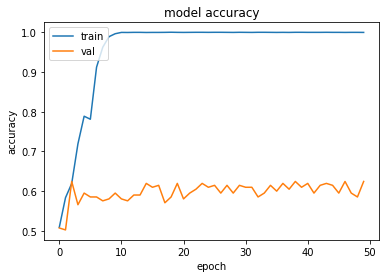

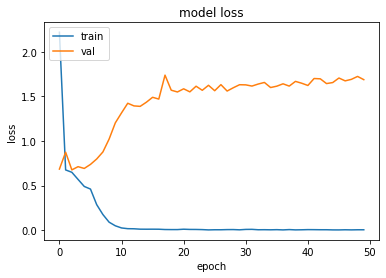

In [15]:
X_train_cross = np.concatenate((X_train, X_valid), axis=0)
y_train_cross = np.concatenate((y_train, y_valid), axis=0)

num_splits = 35

kfold = KFold(n_splits=35, shuffle=True)
genre_splits = create_split(list(dict_genres.values()), num_splits)

fold_no = 1
for train, test in kfold.split(X_train_cross, y_train_cross):
    split = genre_splits[fold_no - 1]
    
    y_train_cross_binary = np.argmax(y_train_cross, axis=1)
    y_train_cross_binary = np.in1d(y_train_cross_binary, split[0])
    y_train_cross_binary = utils.to_categorical(y_train_cross_binary*1, num_classes=2)
    
    print("Folder num {}".format(fold_no))
    genres_name = [[reverse_map[g] for g in split_l] for split_l in split]
    print("Genre split {}".format(genres_name))
    
    model, history  = train_model(X_train_cross[train], y_train_cross_binary[train], X_train_cross[test], y_train_cross_binary[test], "folder{}".format(fold_no), genres_name)
    show_summary_stats(history)
    
    fold_no += 1
    if fold_no > num_splits:
        break